# **O M√©todo de Monte Carlo ‚Äì Algoritmo de Metropolis**
---

## **Dupla**
* Diane Fenzi Gon√ßalves (2019006574)
* Rubia Alice Moreira de Souza (2022043507)

## **Imports**
---


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from numba import jit
import statistics as stat

## **Parte 1: O Algoritmo de Metropolis**
---


### **Cria√ß√£o da Tabela de Vizinhos**
---


Este m√©todo √© capaz de mapear para cada spin os seus vizinhos, gerando uma matriz, com a seguinte estrutura:

* tabelaVizinhos[0]: Vizinhos do spin zero
* tabelaVizinhos[0][0]: Primeiro vizinho do spin zero

Al√©m disso, a tabela garante o tratamento das bordas fazendo uma matriz circular.

In [ ]:
@jit(nopython = True)
def criarTabelaVizinhos(quantidadeSpins: int) -> list[list[float]]:
  def calcularVizinhoDireito(
      indice: int,
      quantidadeSpinsPorLinha: int
    ) -> int:

    ehVizinhoDireitoEmBorda: bool = (
      ((indice + 1) % quantidadeSpinsPorLinha) == 0
    )
    if(ehVizinhoDireitoEmBorda):
      return indice + 1 - quantidadeSpinsPorLinha

    return indice + 1

  def calcularVizinhoSuperior(
      indice: int,
      quantidadeSpins: int,
      quantidadeSpinsPorLinha: int
    ) -> int:

    ehVizinhoSuperiorEmBorda: bool = (
      indice > (quantidadeSpins - 1 - quantidadeSpinsPorLinha)
    )
    if(ehVizinhoSuperiorEmBorda):
      return indice + quantidadeSpinsPorLinha - quantidadeSpins

    return indice + quantidadeSpinsPorLinha

  def calcularVizinhoEsquerdo(
      indice: int,
      quantidadeSpinsPorLinha: int
    ) -> int:

    ehVizinhoEsquerdoEmBorda: bool = indice % quantidadeSpinsPorLinha == 0
    if(ehVizinhoEsquerdoEmBorda):
      return indice + quantidadeSpinsPorLinha - 1

    return indice - 1


  def calcularVizinhoInferior(
      indice: int,
      quantidadeSpins: int,
      quantidadeSpinsPorLinha: int
    ) -> int:

    ehVizinhoInferior: bool = indice < quantidadeSpinsPorLinha
    if(ehVizinhoInferior):
      return indice + quantidadeSpins - quantidadeSpinsPorLinha

    return indice - quantidadeSpinsPorLinha

  quantidadeSpinsPorLinha: int = int(np.sqrt(quantidadeSpins))
  tabelaVizinhos = np.zeros(
      (quantidadeSpins, 4),
      dtype = np.int16
  )

  for i in range(quantidadeSpins):
    tabelaVizinhos[i, 0] = calcularVizinhoDireito(
      i,
      quantidadeSpinsPorLinha
    )

    tabelaVizinhos[i, 1] = calcularVizinhoSuperior(
      i,
      quantidadeSpins,
      quantidadeSpinsPorLinha
    )

    tabelaVizinhos[i, 2] = calcularVizinhoEsquerdo(
      i,
      quantidadeSpinsPorLinha
    )


    tabelaVizinhos[i, 3] = calcularVizinhoInferior(
      i,
      quantidadeSpins,
      quantidadeSpinsPorLinha
    )

  return tabelaVizinhos

Exemplo de tabela:

In [ ]:
criarTabelaVizinhos(25)

array([[ 1,  5,  4, 20],
       [ 2,  6,  0, 21],
       [ 3,  7,  1, 22],
       [ 4,  8,  2, 23],
       [ 0,  9,  3, 24],
       [ 6, 10,  9,  0],
       [ 7, 11,  5,  1],
       [ 8, 12,  6,  2],
       [ 9, 13,  7,  3],
       [ 5, 14,  8,  4],
       [11, 15, 14,  5],
       [12, 16, 10,  6],
       [13, 17, 11,  7],
       [14, 18, 12,  8],
       [10, 19, 13,  9],
       [16, 20, 19, 10],
       [17, 21, 15, 11],
       [18, 22, 16, 12],
       [19, 23, 17, 13],
       [15, 24, 18, 14],
       [21,  0, 24, 15],
       [22,  1, 20, 16],
       [23,  2, 21, 17],
       [24,  3, 22, 18],
       [20,  4, 23, 19]], dtype=int16)

### **Cria√ß√£o do Array de Estados do Sistema**
---


Depois n√≥s precisamos criar um array de valores aleat√≥rios para conseguir definir a configura√ß√£o inicial do sistema que iremos simular.


In [ ]:
@jit(nopython = True)
def criarArrayAleatorio(
    tamanho: int,
    porcentagemNegativos: float = 0.5
  ) -> list[int]:

  arrayInicial = np.random.random(tamanho)
  arrayFormatado = np.zeros(tamanho)

  arrayFormatado[arrayInicial >= porcentagemNegativos] = 1
  arrayFormatado[arrayInicial < porcentagemNegativos] = -1

  return arrayFormatado

Podemos criar uma matriz de valores aleat√≥rios para visualizar o qu√£o aleat√≥rio √© o nosso m√©todo de gerar valores.

Variar o valor de "porcentagemNegativos" vai alterar a distribui√ß√£o de 1 e -1, unificando as cores na matriz.

In [ ]:
def criarMatrizValoresAleatorios(
    tamanho: int,
    porcentagemNegativos: float = 0.5
  ) -> list[int]:

  matrizInicial = np.random.random((tamanho, tamanho))
  matrizFormatado = np.zeros((tamanho, tamanho))

  matrizFormatado[matrizInicial >= porcentagemNegativos] = 1
  matrizFormatado[matrizInicial < porcentagemNegativos] = -1

  return matrizFormatado

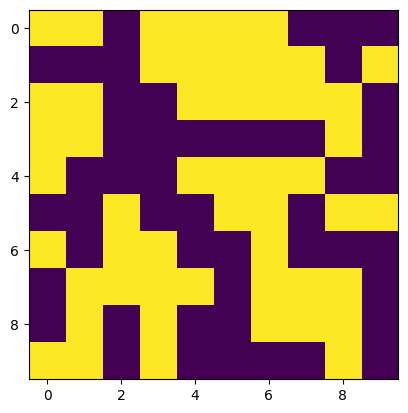

In [ ]:
plt.imshow(criarMatrizValoresAleatorios(10, 0.5))

### **Calculo Magnetiza√ß√£o**
---


O c√°lculo da magnetiza√ß√£o ser√° feita da seguinte forma:


In [ ]:
@jit(nopython = True)
def calcularMagnetizacao(
    estadoSistema: list[int]
  ) -> int:
  return np.sum(estadoSistema)

### **Calculo de Energia**
---


O c√°lculo da energia √© feita da seguinte forma:

In [ ]:
@jit(nopython = True)
def calcularEnergiaTotal(
    estadoSistema: list[int],
    tabelaVizinhos: list[list[int]]
  ) -> float:

  quantidadeSpins: int = len(estadoSistema)
  energia: float = 0

  for i in range(quantidadeSpins):
    vizinhoDireito: int = tabelaVizinhos[i, 0]
    VizinhoSuperior: int = tabelaVizinhos[i, 1]
    somaSpinsSuperiorEDireito: float = (
        estadoSistema[vizinhoDireito] + estadoSistema[VizinhoSuperior]
    )
    energia -= estadoSistema[i] * somaSpinsSuperiorEDireito

  return energia

### **Calculo da Varia√ß√£o de Energia**
---


O c√°culo da varia√ß√£o de energia pode ser feito da forma abaixo. Contudo, ela n√£o ser√° utilizada no final, pois os poss√≠veis resultados s√£o -8, -4, 0, 4, 8. Assim, podemos pr√©-computar os resultados e utilizaremos esses valores para executar o algoritmo mais r√°pido.

In [ ]:
def calcularEnergiaSpin(
    estadoSistema: list[int],
    tabelaVizinhos: list[list[int]],
    indiceSpinAlvo: int = 0
  ) -> int:

  spin: int = estadoSistema[indiceSpinAlvo]
  spinsVizinhos: list[int] = (
    [estadoSistema[indiceVizinho] for indiceVizinho in tabelaVizinhos[indiceSpinAlvo]]
  )

  return 2 * spin * np.sum(spinsVizinhos)

In [ ]:
def calcularEnergiaSpinFlipado(
    estadoSistema: list[int],
    tabelaVizinhos: list[list[int]],
    indiceSpinAlvo: int = 0
  ) -> int:

  spin: int = estadoSistema[indiceSpinAlvo]
  spinsVizinhos: list[int] = (
    [estadoSistema[indiceVizinho] for indiceVizinho in tabelaVizinhos[indiceSpinAlvo]]
  )

  return -2 * -spin * np.sum(spinsVizinhos)

### **Algoritmo Metr√≥polis**
---



A seguir temos a implementa√ß√£o do Algoritmo de metr√≥polis, que depois utilizaremos o modelo de Ising.

**Observa√ß√£o:** Beta = 1 / temperatura

#### **Implementa√ß√£o Otimizada - Algoritmo Metropolis**
---


In [ ]:
@jit(nopython = True)
def criarTabelaExponenciais(beta: float) -> list[float]:
    tabelaExponenciais = np.zeros(5, dtype = np.float32)

    tabelaExponenciais[0] = np.exp(8.0 * beta)
    tabelaExponenciais[1] = np.exp(4.0 * beta)
    tabelaExponenciais[2] = 1.0
    tabelaExponenciais[3] = np.exp(-4.0 * beta)
    tabelaExponenciais[4] = np.exp(-8.0 * beta)

    return tabelaExponenciais

In [ ]:
@jit(nopython = True)
def calcularIndiceExponencial(
    estadoSistema: list[int],
    tabelaVizinhos: list[list[int]],
    spinAlvo: int
) -> int:

  somaVizinhos = (
    estadoSistema[tabelaVizinhos[spinAlvo][0]] +
    estadoSistema[tabelaVizinhos[spinAlvo][1]] +
    estadoSistema[tabelaVizinhos[spinAlvo][2]] +
    estadoSistema[tabelaVizinhos[spinAlvo][3]]
  )
  resultado = int(
      estadoSistema[spinAlvo] * somaVizinhos * 0.5 + 2
  )

  return resultado

In [ ]:
@jit(nopython = True)
def calcularSomaVizinhos(
    estadoSistema: list[int],
    listaVizinhos: list[list[int]],
    spinAlvo: int
  ) -> int:

  somaVizinhos = (
    estadoSistema[listaVizinhos[spinAlvo, 0]] +
    estadoSistema[listaVizinhos[spinAlvo, 1]] +
    estadoSistema[listaVizinhos[spinAlvo, 2]] +
    estadoSistema[listaVizinhos[spinAlvo, 3]]
  )

  return somaVizinhos

In [ ]:
@jit(nopython = True)
def calcularIndiceExponencial(
    estadoSistema: list[int],
    somaVizinhos: int,
    spinAlvo: int
  ) -> int:

  return int(
      estadoSistema[spinAlvo] * somaVizinhos * 0.5 + 2
  )

In [ ]:
@jit(nopython = True)
def executarAlgoritmoMetropolis(
    quantidadeSpins: int,
    estadoSistema: list[int],
    listaVizinhos: list[list[int]],
    tabelaExponenciais: list[float],
    energiaSistema: float,
    magnetizacaoSistema: float
  ) -> tuple[float, float]:

  for j in range(quantidadeSpins):
    spinAlvo: int = np.random.randint(quantidadeSpins)

    somaVizinhos: int = calcularSomaVizinhos(
        estadoSistema,
        listaVizinhos,
        spinAlvo
    )
    indiceExponencial: int = calcularIndiceExponencial(
        estadoSistema,
        somaVizinhos,
        spinAlvo
    )

    # Otimiza√ß√£o: resultado: float = np.exp(-beta * variacaoEnergia)
    resultado: float = tabelaExponenciais[indiceExponencial]
    valorAleatorio: float = np.random.rand()

    if(valorAleatorio <= resultado):
      energiaSistema += 2 * estadoSistema[spinAlvo] * somaVizinhos
      magnetizacaoSistema += -2 * estadoSistema[spinAlvo]
      estadoSistema[spinAlvo] *= -1

  return (energiaSistema, magnetizacaoSistema)

In [ ]:
@jit(nopython = True)
def simularMetropolisPorModeloIsing(
    quantidadeSpins: int,
    temperatura: float,
    quantidadePassos: int
  ) -> tuple[list[float], list[float]]:

  beta: float = 1 / temperatura
  tabelaExponenciais: list[float] = criarTabelaExponenciais(beta)
  estadoSistema: list[int] = criarArrayAleatorio(quantidadeSpins)
  listaVizinhos: list[list[int]] = criarTabelaVizinhos(quantidadeSpins)

  energiasRegistradas: list[float] = np.zeros(quantidadePassos + 1)
  energiaSistema: float = calcularEnergiaTotal(estadoSistema, listaVizinhos)
  energiasRegistradas[0] = energiaSistema

  magnetizacaosRegistradas: list[float] = np.zeros(quantidadePassos + 1)
  magnetizacaoSistema: float = calcularMagnetizacao(estadoSistema)
  magnetizacaosRegistradas[0] = magnetizacaoSistema

  for i in range(1, quantidadePassos + 1):
    (energiaSistema, magnetizacaoSistema) = executarAlgoritmoMetropolis(
        quantidadeSpins,
        estadoSistema,
        listaVizinhos,
        tabelaExponenciais,
        energiaSistema,
        magnetizacaoSistema
    )

    energiasRegistradas[i] = energiaSistema
    magnetizacaosRegistradas[i] = magnetizacaoSistema

  return (energiasRegistradas, magnetizacaosRegistradas)

In [ ]:
def plotSimulacaoMetropolis(
    energiasRegistradas: list[float],
    magnetizacaosRegistradas: list[float]
) -> None:

  fig, ax = plt.subplots(1, 2, figsize = (15, 5))

  ax[0].plot(energiasRegistradas)
  ax[0].set_title("Evolu√ß√£o temporal energia total")
  ax[0].set_xlabel("Quantidade de passos")
  ax[0].set_ylabel("Energia")

  ax[1].plot(magnetizacaosRegistradas)
  ax[1].set_title("Evolu√ß√£o temporal magnetiza√ß√£o total")
  ax[1].set_xlabel("Quantidade de passos")
  ax[1].set_ylabel("Magnetiza√ß√£o")
  plt.show()

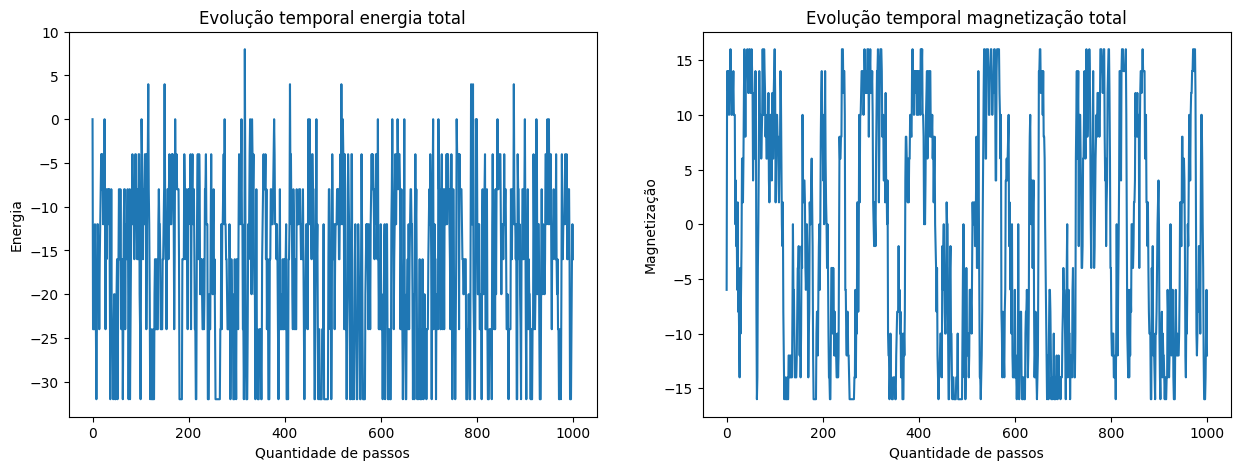

In [ ]:
(energiasRegistradas, magnetizacaosRegistradas) = simularMetropolisPorModeloIsing(
    quantidadeSpins = 16,
    temperatura = 3,
    quantidadePassos = 1000
)

plotSimulacaoMetropolis(energiasRegistradas, magnetizacaosRegistradas)

### **Explora√ß√£o com Simula√ß√µes e An√°lise de Resultados**
---

#### **Agrupando diversas simula√ß√µes de mesmo tipo**
---

Abaixo, temos o gr√°fico de magnetiza√ß√£o e energia ao realizar 7 simula√ß√µes com par√¢metros diferentes e para cada uma realizamos 20 testes:

##### **Resultado Energias**
---


In [1]:
def plotEnergiaVariasSimulacoesComParametrosIguais(
    quantidadeSimulacoes: int,
    quantidadePassosSimulacoes: int,
    quantidadeSpinsSimulacoes: list[int],
    temperaturasSimulacoes: list[float]
  ) -> None:
  quantidadeTiposSimulacoes = len(quantidadeSpinsSimulacoes)

  energiasPorSimulacoes: list[list[float]] = []
  magnetizacaosPorSimulacoes: list[list[float]] = []

  figure1, axis1 = plt.subplots(quantidadeTiposSimulacoes, 3, figsize = (9, 5))

  for i in range(quantidadeTiposSimulacoes):
    for j in range(quantidadeSimulacoes):
      (energiasRegistradas, magnetizacaosRegistradas) = simularMetropolisPorModeloIsing(
          quantidadeSpins = quantidadeSpinsSimulacoes[i],
          temperatura = temperaturasSimulacoes[i],
          quantidadePassos = quantidadePassosSimulacoes
      )

      axis1[i].plot(energiasRegistradas)
      axis1[i].set_title(f"Simula√ß√£o {i}")
      axis1[i].set_xlabel("Quantidade de passos")
      axis1[i].set_ylabel("Energia")

  figure1.subplots_adjust(top = 6)
  plt.show()

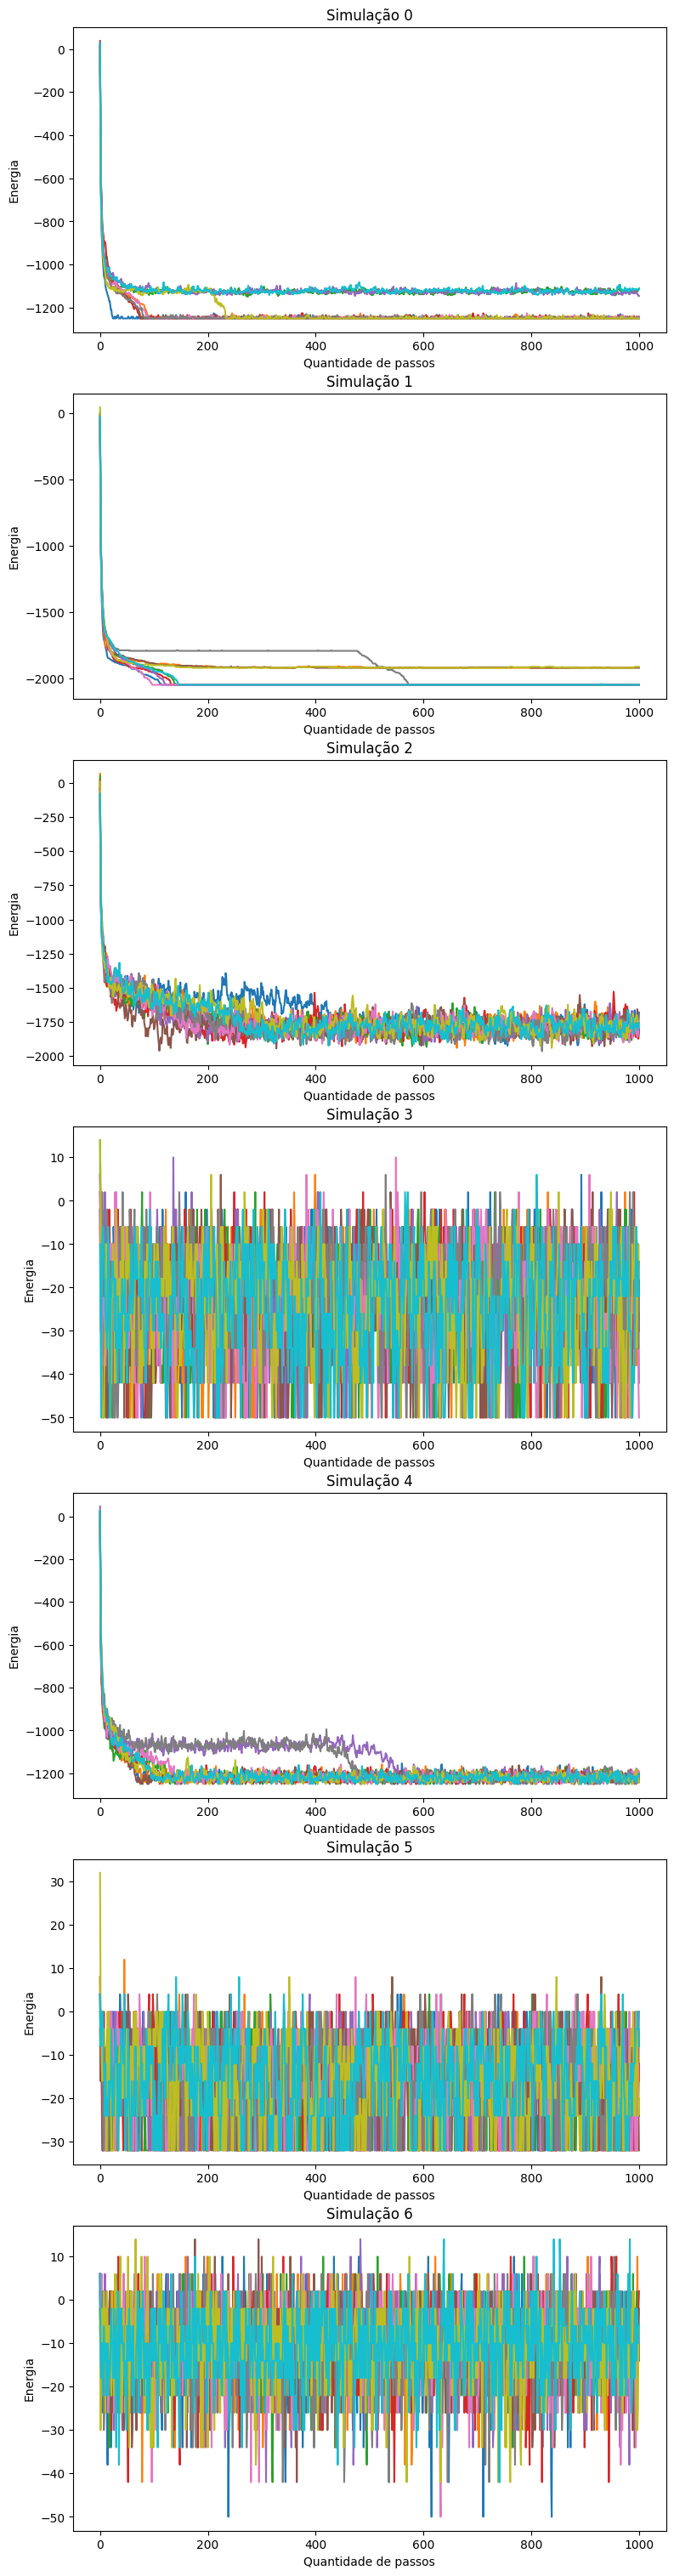

In [ ]:
plotEnergiaVariasSimulacoesComParametrosIguais(
  quantidadeSimulacoes = 10,
  quantidadePassosSimulacoes = 1000,
  quantidadeSpinsSimulacoes = [625, 1024, 1024, 25, 625, 16, 25],
  temperaturasSimulacoes = [1, 0.5, 2, 3, 1.5, 3, 5]
)

##### **Resultado magnetiza√ß√µes**
---


In [ ]:
def plotMagnetizacaoVariasSimulacoesComParametrosIguais(
    quantidadeSimulacoes: int,
    quantidadePassosSimulacoes: int,
    quantidadeSpinsSimulacoes: list[int],
    temperaturasSimulacoes: list[float]
  ) -> None:
  quantidadeTiposSimulacoes = len(quantidadeSpinsSimulacoes)

  energiasPorSimulacoes: list[list[float]] = []
  magnetizacaosPorSimulacoes: list[list[float]] = []

  figure2, axis2 = plt.subplots(quantidadeTiposSimulacoes, 1, figsize = (15, 15))

  for i in range(quantidadeTiposSimulacoes):
    for j in range(quantidadeSimulacoes):
      (energiasRegistradas, magnetizacaosRegistradas) = simularMetropolisPorModeloIsing(
          quantidadeSpins = quantidadeSpinsSimulacoes[i],
          temperatura = temperaturasSimulacoes[i],
          quantidadePassos = quantidadePassosSimulacoes
      )

      axis2[i].plot(magnetizacaosRegistradas)
      axis2[i].set_title(f"Simula√ß√£o {i}")
      axis2[i].set_xlabel("Quantidade de passos")
      axis2[i].set_ylabel("Magnetiza√ß√£o")

  figure2.subplots_adjust(top = 3)
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

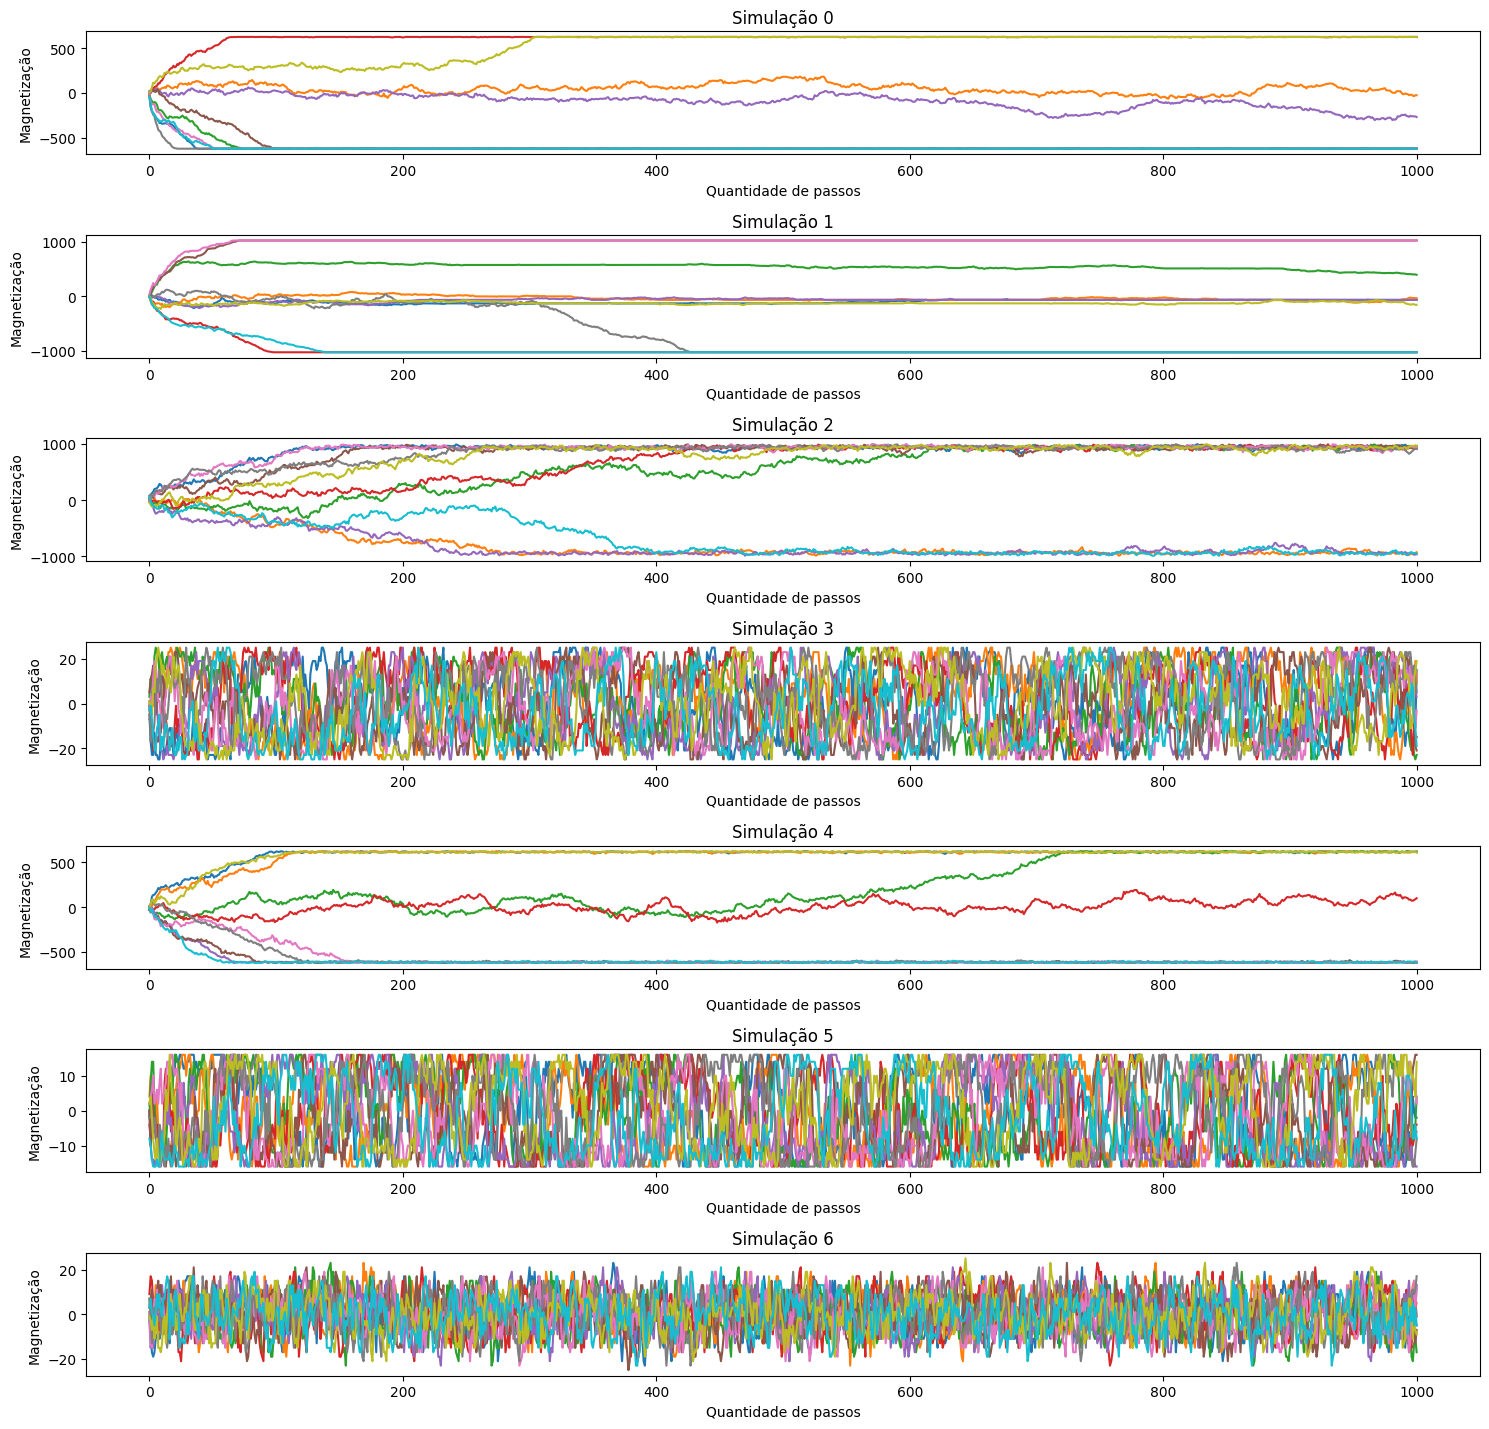

In [ ]:
plotMagnetizacaoVariasSimulacoesComParametrosIguais(
  quantidadeSimulacoes = 10,
  quantidadePassosSimulacoes = 1000,
  quantidadeSpinsSimulacoes = [625, 1024, 1024, 25, 625, 16, 25],
  temperaturasSimulacoes = [1, 0.5, 2, 3, 1.5, 3, 5]
)

#### **Agrupando diferentes simula√ß√µes**
---

J√° neste caso, realizamos 1 teste para cada um dos 7 tipos de simula√ß√µes diferentes (com diferentes conjuntos de par√¢metros) e as agrupamos em um mesmo gr√°fico:

In [ ]:
def realizarSimulacoesSimultaneas(
    quantidadePassosSimulacoes: int,
    quantidadeSpinsSimulacoes: list[int],
    temperaturasSimulacoes: list[float]
  ) -> None:

  quantidadeSimulacoes: int = len(quantidadeSpinsSimulacoes)

  energiasPorSimulacoes: list[list[float]] = []
  magnetizacaosPorSimulacoes: list[list[float]] = []

  figure1, axis1 = plt.subplots(1, 1)
  figure2, axis2 = plt.subplots(1, 1)
  labels = []

  for i in range(quantidadeSimulacoes):
    (energiasRegistradas, magnetizacaosRegistradas) = simularMetropolisPorModeloIsing(
        quantidadeSpins = quantidadeSpinsSimulacoes[i],
        temperatura = temperaturasSimulacoes[i],
        quantidadePassos = quantidadePassosSimulacoes
    )

    labels.append(f"Temperatura: {temperaturasSimulacoes[i]}, Rede: {int(np.sqrt(quantidadeSpinsSimulacoes[i]))}x{int(np.sqrt(quantidadeSpinsSimulacoes[i]))}")
    axis1.set_title(f"Energia total - {quantidadeSimulacoes} Simula√ß√µes")
    axis1.set_xlabel("Quantidade de passos")
    axis1.set_ylabel("Energia")
    axis1.plot(energiasRegistradas)

    axis2.set_title(f"Magnetiza√ß√£o total - {quantidadeSimulacoes} Tipos Simula√ß√µes")
    axis2.set_xlabel("Quantidade de passos")
    axis2.set_ylabel("Magnetiza√ß√£o")
    axis2.plot(magnetizacaosRegistradas)

  axis1.legend(labels = labels, loc = 'upper left', bbox_to_anchor = (1, 1))
  axis2.legend(labels = labels, loc = 'upper left', bbox_to_anchor = (1, 1))
  plt.show()

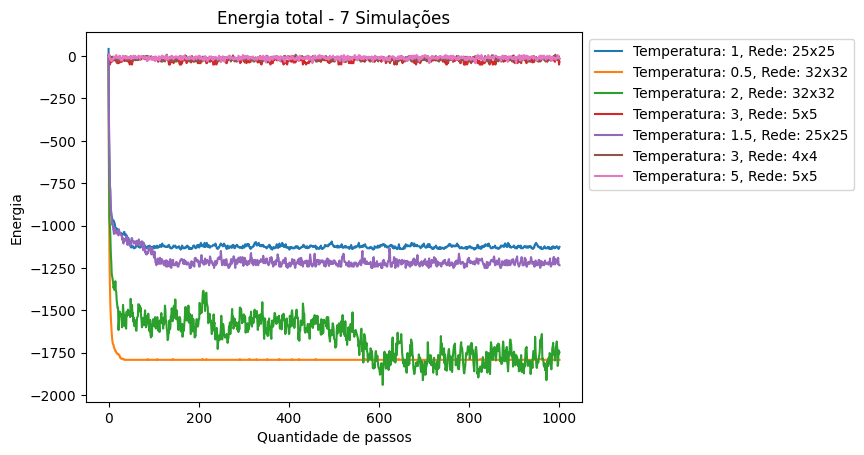

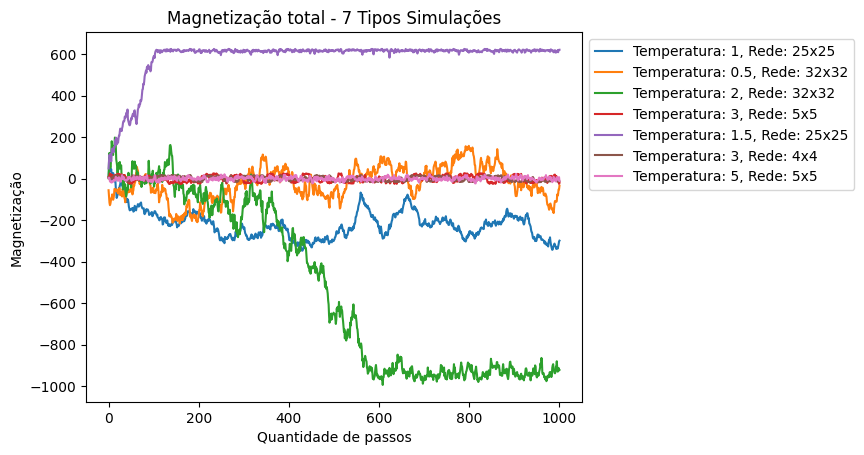

In [ ]:
realizarSimulacoesSimultaneas(
  quantidadePassosSimulacoes = 1000,
  quantidadeSpinsSimulacoes = [625, 1024, 1024, 25, 625, 16, 25],
  temperaturasSimulacoes = [1, 0.5, 2, 3, 1.5, 3, 5]
)

#### **An√°lise**
---

Como estudado em sala, o que observamos aqui √© a partida de um ponto aleat√≥rio na curva de magnetiza√ß√£o at√© encontrar um ponto de vale. N√≥s avan√ßamos a ele √† medida que a energia reduz, como √© poss√≠vel notar nos outros gr√°ficos. Quando chegamos nesse ponto, n√≥s acabamos encontrando uma oscila√ß√£o sobre um valor m√©dio, que pode ser uma termaliza√ß√£o, caso esteja convergindo consistentemente para ele.

A quantidade de passos necess√°rios para chegar a um estado de termaliza√ß√£o √©, fazendo um chute alto, √© de 600 a 800 passos. Contudo, diversas simula√ß√µes n√£o chegaram a um ponto de termaliza√ß√£o nem com 1000 passos, como as simula√ß√µes 0, 1, 4. Por outro lado, outras j√° conseguiram chegar a termaliza√ß√£o ou iniciar nela, como nos casos 2, 3, 5 e 6.

Por meio dessa an√°lise qualitativa utilizando os gr√°ficos, verificamos que o n√∫mero de passos para atingir a termaliza√ß√£o, realmente, varia segundo o tamanho do sistema e a temperatura. Segundo nossos testes, acreditamos que quanto maior a temperatura (energia) mais f√°cil ser√° atingir o estado de termaliza√ß√£o, o que tamb√©m se aplica a quanto menor for o tamanho da rede de spins.

### **Simular Processo de Termaliza√ß√£o**
---


Uma vez que j√° somos capazes de simular com o algoritmo de Metropolis. Podemos criar um algoritmo para descartar valores e chegar a um ponto de termaliza√ß√£o, retornando apenas ele.

Segundo a an√°lise realizada e os resultados obtidos, √© poss√≠vel notar que os valores de 600 e 800 s√£o pontos onde os valores costumam come√ßar a oscilar sobre uma m√©dia, como no caso da Simula√ß√£o 2 feita anteriormente.

In [ ]:
def simularTermalizacao(
    quantidadeSpins: int,
    temperatura: float,
    quantidadePassosDescartados: int,
    quantidadePassosUteis: int
  ) -> list[float, float, float, float]:

  energiasDescartadas: list[float] = np.zeros(quantidadePassosDescartados)
  magnetizacoesDescartadas: list[float] = np.zeros(quantidadePassosDescartados)

  beta: float = 1 / temperatura
  tabelaExponenciais = criarTabelaExponenciais(beta)
  estadoSistema: list[int] = criarArrayAleatorio(quantidadeSpins)
  listaVizinhos: list[list[int]] = criarTabelaVizinhos(quantidadeSpins)

  energiaSistema: float = calcularEnergiaTotal(estadoSistema, listaVizinhos)
  magnetizacaoSistema: float = calcularMagnetizacao(estadoSistema)

  for i in range(quantidadePassosDescartados):
    (energiaSistema, magnetizacaoSistema) = executarAlgoritmoMetropolis(
        quantidadeSpins,
        estadoSistema,
        listaVizinhos,
        tabelaExponenciais,
        energiaSistema,
        magnetizacaoSistema
    )

    energiasDescartadas[i] = energiaSistema
    magnetizacoesDescartadas[i] = magnetizacaoSistema

  energias: list[float] = np.zeros(quantidadePassosUteis)
  magnetizacoes: list[float] = np.zeros(quantidadePassosUteis)

  for i in range(quantidadePassosUteis):
    (energiaSistema, magnetizacaoSistema) = executarAlgoritmoMetropolis(
        quantidadeSpins,
        estadoSistema,
        listaVizinhos,
        tabelaExponenciais,
        energiaSistema,
        magnetizacaoSistema
    )

    energias[i] = energiaSistema
    magnetizacoes[i] = magnetizacaoSistema

  return (
    energias, magnetizacoes, energiasDescartadas, magnetizacoesDescartadas
  )

In [ ]:
(energiasRegistradas, magnetizacaosRegistradas,
 energiasDescartadas, magnetizacoesDescartadas) = simularTermalizacao(
    quantidadeSpins = 1024,
    temperatura = 2,
    quantidadePassosDescartados = 600,
    quantidadePassosUteis = 400
)

Utilizando os mesmos par√¢metros da simula√ß√£o 2, iremos gerar um gr√°fico apenas com os valores partindo do ponto de termaliza√ß√£o e ignorando os passos anteriores. Ou seja, iremos partir depois dos 600 primeiros passos dentre o total de 1000.

Resultados Relevantes


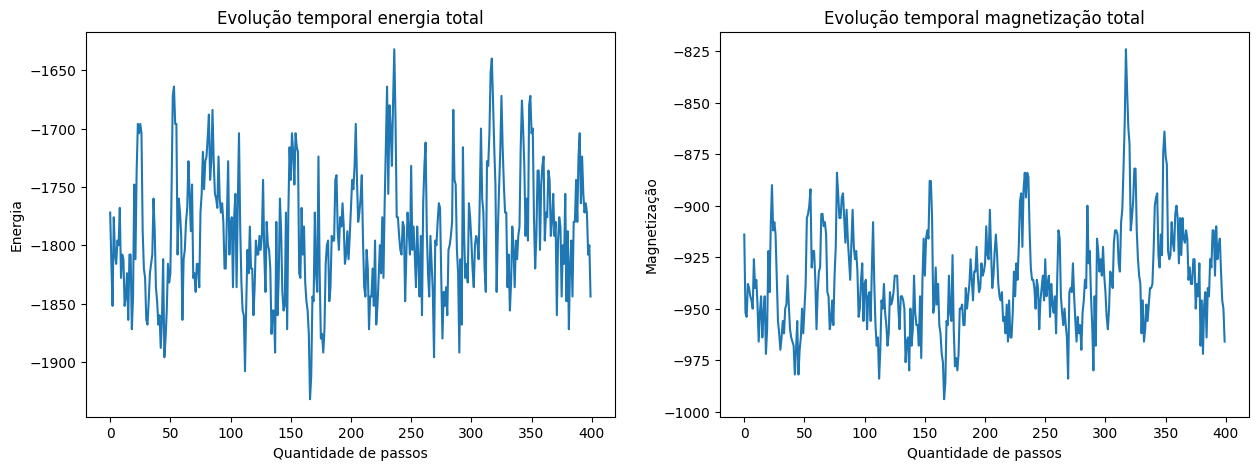

In [ ]:
print("Resultados Relevantes")
plotSimulacaoMetropolis(energiasRegistradas, magnetizacaosRegistradas)

√â poss√≠vel notar nos gr√°ficos anteriores que eles oscilam entre valores m√©dios espec√≠ficos.

Agora, podemos testar os valores anteriores a eles. Iremos criar um gr√°fico para os valores de energia e magnetiza√ß√£o total que foram descartados antes da termaliza√ß√£o:

Resultados Descartados


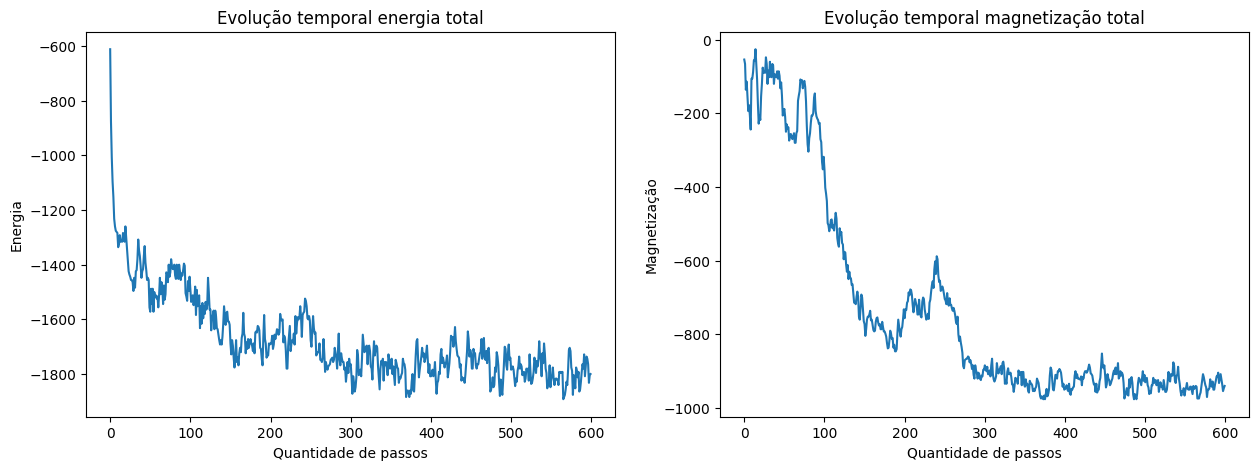

In [ ]:
print("Resultados Descartados")
plotSimulacaoMetropolis(energiasDescartadas, magnetizacoesDescartadas)

## **Parte 2: Erros Estat√≠sticos**
---


In [ ]:
TAMANHO_TERMALIZADOS: list[int] = [1024, 25, 100, 16]
TEMPERATURAS_TERMALIZADAS: list[float] = [2, 3, 1.5, 3]

In [ ]:
def calcularCalorEspecifico(
    energia: list[float],
    temperatura: float,
    quantidadeSpins: int
  ) -> float:

  beta: float = 1 / temperatura
  mediaEnergia: float = stat.mean(energia)
  mediaEnergiaQuadrado: float = stat.mean(np.square(energia))
  calorEspecifico: float = (
    (beta**2) / quantidadeSpins * (mediaEnergiaQuadrado - (mediaEnergia**2))
  )

  return calorEspecifico

In [ ]:
def calcularSusceptibilidadeMagnetizacao(
    magnetizacao: list[float],
    temperatura: float,
    quantidadeSpins: int
  ) -> float:

  beta: float = 1 / temperatura
  mediaMagnetizacao: float = stat.mean(np.abs(magnetizacao))
  mediaMagnetizacaoQuadrado: float = stat.mean(np.square(magnetizacao))
  magnetizacao: float = (
    beta / quantidadeSpins * (mediaMagnetizacaoQuadrado - (mediaMagnetizacao**2))
  )

  return magnetizacao

In [ ]:
def calcularErroEstatistico(valores: list[float]) -> float:
  tamanho: int = len(valores)
  media: float = stat.mean(valores)
  diferencaQuadrada: float = (valores - media) ** 2
  erroEstatistico: float = np.sqrt(
      np.sum(diferencaQuadrada) / (tamanho * (tamanho - 1))
  )

  return erroEstatistico

In [ ]:
def calcularEstatisticasModeloIsing(
    quantidadeBlocos: int,
    quantidadeSpins: int,
    temperatura: float,
    quantidadePassosDescartados: int,
    quantidadePassosUteis: int
) -> list[float, float]:
  (energiasRegistradas, magnetizacoesRegistradas,
   energiasDescartadas, magnetizacoesDescartadas) = simularTermalizacao(
      quantidadeSpins,
      temperatura,
      quantidadePassosDescartados,
      quantidadePassosUteis
  )

  energiasPorBlocos = np.array_split(
    energiasRegistradas,
    quantidadeBlocos
  )

  magnetizacaoPorBlocos = np.array_split(
    magnetizacoesRegistradas,
    quantidadeBlocos
  )

  mediasEnergiasPorBlocos: list[float] = np.zeros(quantidadeBlocos)
  mediasMagnetizacaoPorBlocos: list[float] = np.zeros(quantidadeBlocos)
  mediasMagnetizacaoAbsolutaPorBloco: list[float] = np.zeros(quantidadeBlocos)
  energiaPorSpin: list[float] = np.zeros(quantidadeBlocos)
  magnetizacaoPorSpin: list[float] = np.zeros(quantidadeBlocos)
  caloresEspecificos: list[float] = np.zeros(quantidadeBlocos)
  susceptibilidadesMagnetizacao: list[float] = np.zeros(quantidadeBlocos)

  for i in range(quantidadeBlocos):
    mediasEnergiasPorBlocos[i] = np.mean(energiasPorBlocos[i])
    mediasMagnetizacaoPorBlocos[i] = np.mean(magnetizacaoPorBlocos[i])
    mediasMagnetizacaoAbsolutaPorBloco[i] = np.mean(
      np.abs(magnetizacaoPorBlocos[i])
    )
    energiaPorSpin[i] = mediasEnergiasPorBlocos[i] / quantidadeSpins
    magnetizacaoPorSpin[i] = mediasMagnetizacaoPorBlocos[i] / quantidadeSpins
    caloresEspecificos[i] = calcularCalorEspecifico(
      energiasPorBlocos[i],
      temperatura,
      quantidadeSpins
    )
    susceptibilidadesMagnetizacao[i] = calcularSusceptibilidadeMagnetizacao(
      magnetizacaoPorBlocos[i],
      temperatura,
      quantidadeSpins
    )

  calorEspecificoFinal: float = np.mean(caloresEspecificos)
  erroEstatisticoCalorEspecifico = calcularErroEstatistico(caloresEspecificos)

  susceptibilidadeFinal: float = np.mean(susceptibilidadesMagnetizacao)
  erroEstatisticoSusceptibilidade = calcularErroEstatistico(
    susceptibilidadesMagnetizacao
  )

  energiaPorSpinFinal: float = np.mean(energiaPorSpin)
  erroEstatisticoEnergiaPorSpin = calcularErroEstatistico(energiaPorSpin)

  magnetizacaoPorSpinFinal: float = np.mean(magnetizacaoPorSpin)
  erroEstatisticoMagnetizacaoPorSpin = calcularErroEstatistico(
    magnetizacaoPorSpin
  )

  energiaFinal: float = np.mean(mediasEnergiasPorBlocos)
  erroEstatisticoEnergiaFinal = calcularErroEstatistico(mediasEnergiasPorBlocos)

  magnetizacaoFinal: float = np.mean(mediasMagnetizacaoPorBlocos)
  erroEstatisticoMagnetizacaoFinal = calcularErroEstatistico(
    mediasMagnetizacaoPorBlocos
  )

  resultados = {
      "mediasEnergiasPorBlocos": mediasEnergiasPorBlocos,
      "mediasMagnetizacaoPorBlocos": mediasMagnetizacaoPorBlocos,
      "mediasMagnetizacaoAbsolutaPorBloco": mediasMagnetizacaoAbsolutaPorBloco,
      "energiaPorSpin": energiaPorSpin,
      "magnetizacaoPorSpin": magnetizacaoPorSpin,
      "caloresEspecificos": caloresEspecificos,
      "susceptibilidadesMagnetizacao": susceptibilidadesMagnetizacao,
      "calorEspecificoFinal": calorEspecificoFinal,
      "susceptibilidadeFinal": susceptibilidadeFinal,
      "energiaPorSpinFinal": energiaPorSpinFinal,
      "magnetizacaoPorSpinFinal": magnetizacaoPorSpinFinal,
      "energiaFinal": energiaFinal,
      "magnetizacaoFinal": magnetizacaoFinal,
      "erroEstatisticoCalorEspecifico": erroEstatisticoCalorEspecifico,
      "erroEstatisticoSusceptibilidade": erroEstatisticoSusceptibilidade,
      "erroEstatisticoEnergiaPorSpin": erroEstatisticoEnergiaPorSpin,
      "erroEstatisticoMagnetizacaoPorSpin": erroEstatisticoMagnetizacaoPorSpin,
      "erroEstatisticoEnergiaFinal": erroEstatisticoEnergiaFinal,
      "erroEstatisticoMagnetizacaoFinal": erroEstatisticoMagnetizacaoFinal,
      "erroMedio": np.mean([
        erroEstatisticoCalorEspecifico,
        erroEstatisticoSusceptibilidade,
        erroEstatisticoEnergiaPorSpin,
        erroEstatisticoMagnetizacaoPorSpin,
        erroEstatisticoEnergiaFinal,
        erroEstatisticoMagnetizacaoFinal
      ])
  }

  return resultados

In [ ]:
calcularEstatisticasModeloIsing(
    quantidadeBlocos = 10,
    quantidadeSpins = TAMANHO_TERMALIZADOS[0],
    temperatura = TEMPERATURAS_TERMALIZADAS[0],
    quantidadePassosDescartados = 600,
    quantidadePassosUteis = 400
)

{'mediasEnergiasPorBlocos': array([-1767.4, -1771.5, -1798.4, -1794.9, -1764.7, -1796.4, -1785.4,
        -1767.3, -1813.6, -1798.1]),
 'mediasMagnetizacaoPorBlocos': array([-917.55, -926.3 , -941.1 , -941.3 , -919.15, -930.75, -935.3 ,
        -921.55, -948.1 , -939.9 ]),
 'mediasMagnetizacaoAbsolutaPorBloco': array([917.55, 926.3 , 941.1 , 941.3 , 919.15, 930.75, 935.3 , 921.55,
        948.1 , 939.9 ]),
 'energiaPorSpin': array([-1.72597656, -1.72998047, -1.75625   , -1.75283203, -1.72333984,
        -1.75429688, -1.74355469, -1.72587891, -1.77109375, -1.75595703]),
 'magnetizacaoPorSpin': array([-0.89604492, -0.90458984, -0.91904297, -0.91923828, -0.89760742,
        -0.90893555, -0.91337891, -0.89995117, -0.92587891, -0.91787109]),
 'caloresEspecificos': array([0.28584961, 0.64691162, 0.35347656, 0.88671631, 1.13884521,
        0.68433594, 0.54209961, 0.39060303, 0.64429688, 0.62577881]),
 'susceptibilidadesMagnetizacao': array([0.16869995, 0.25259277, 0.11903809, 0.30581543, 0.66

### **Comportamentos variando apenas a temperatura**
---


In [ ]:
TEMPERATURA_MINIMA: int = -35
TEMPERATURA_MAXIMA: int = 35

#### **Varia√ß√£o do  erro em fun√ß√£o da temperatura**
---


In [ ]:
def simularVariacaoAtributoEmFuncaoTemperatura(
    temperaturaMinima: float,
    temperaturaMaxima: float,
    quantidadeBlocos: int,
    quantidadeSpins: int,
    quantidadePassosDescartados: int,
    quantidadePassosUteis: int,
    atributo,
    atributoErroEstatistico
  ) -> None:

  energiaPorSpinFinal: list[float] = []
  temperaturas: list[float] = []
  erroEstatistico: list[float] = []

  figResultado, axResultado = plt.subplots(1, 2, figsize = (10, 5))

  for temperatura in range(temperaturaMinima, temperaturaMaxima):
    if temperatura == 0:
      continue

    resultados = calcularEstatisticasModeloIsing(
        quantidadeBlocos = quantidadeBlocos,
        quantidadeSpins = quantidadeSpins,
        temperatura = temperatura,
        quantidadePassosDescartados = quantidadePassosDescartados,
        quantidadePassosUteis = quantidadePassosUteis
    )

    energiaPorSpinFinal.append(resultados[atributo])
    temperaturas.append(temperatura)
    erroEstatistico.append(resultados[atributoErroEstatistico])

  axResultado[0].set_xlabel("Temperatura")
  axResultado[0].set_ylabel(atributo)
  axResultado[0].set_title(atributo)
  axResultado[0].plot(temperaturas, energiaPorSpinFinal)

  axResultado[1].set_xlabel("Temperatura")
  axResultado[1].set_ylabel(atributoErroEstatistico)
  axResultado[1].set_title(atributoErroEstatistico)
  axResultado[1].plot(temperaturas, erroEstatistico)
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

#### **Energia por spin em fun√ß√£o da temperatura**
---


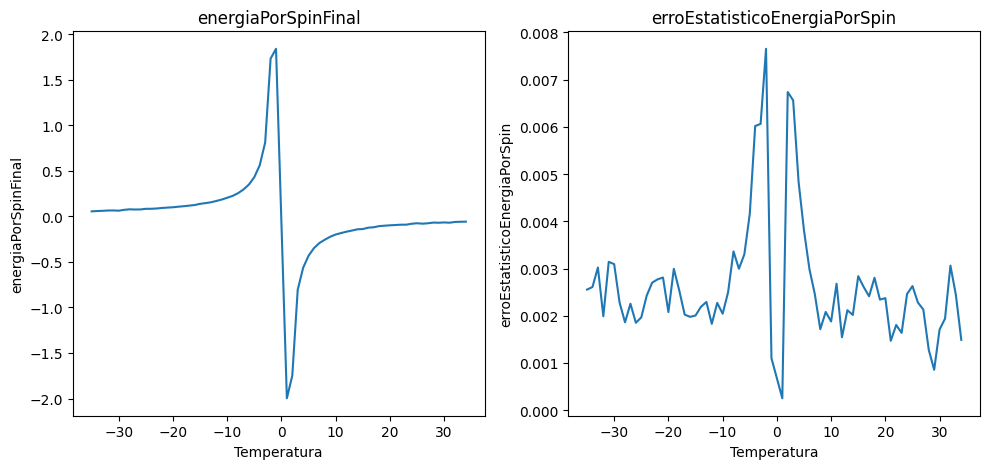

In [ ]:
simularVariacaoAtributoEmFuncaoTemperatura(
  temperaturaMinima = TEMPERATURA_MINIMA,
  temperaturaMaxima = TEMPERATURA_MAXIMA,
  quantidadeBlocos = 10,
  quantidadeSpins = TAMANHO_TERMALIZADOS[0],
  quantidadePassosDescartados = 600,
  quantidadePassosUteis = 400,
  atributo = "energiaPorSpinFinal",
  atributoErroEstatistico = "erroEstatisticoEnergiaPorSpin"
)

#### **Magnetiza√ß√£o em fun√ß√£o da temperatura**
---


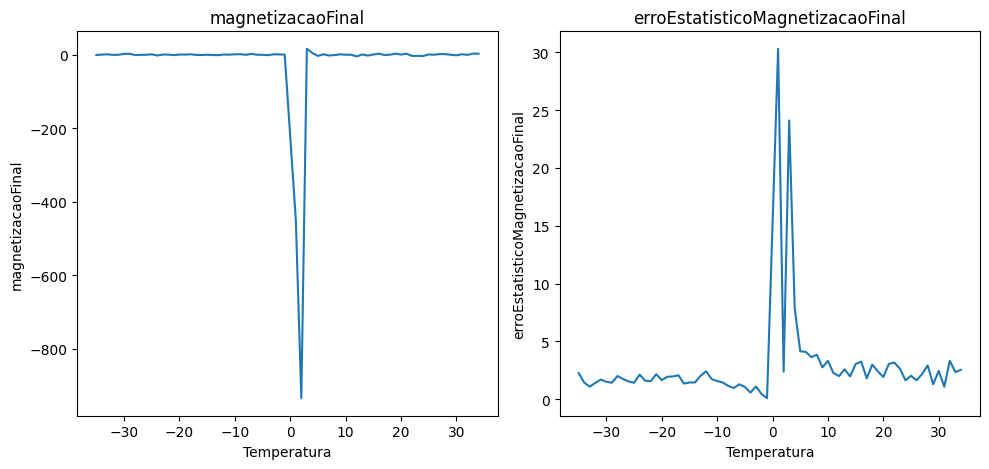

In [ ]:
simularVariacaoAtributoEmFuncaoTemperatura(
  temperaturaMinima = TEMPERATURA_MINIMA,
  temperaturaMaxima = TEMPERATURA_MAXIMA,
  quantidadeBlocos = 10,
  quantidadeSpins = TAMANHO_TERMALIZADOS[0],
  quantidadePassosDescartados = 600,
  quantidadePassosUteis = 400,
  atributo = "magnetizacaoFinal",
  atributoErroEstatistico = "erroEstatisticoMagnetizacaoFinal"
)

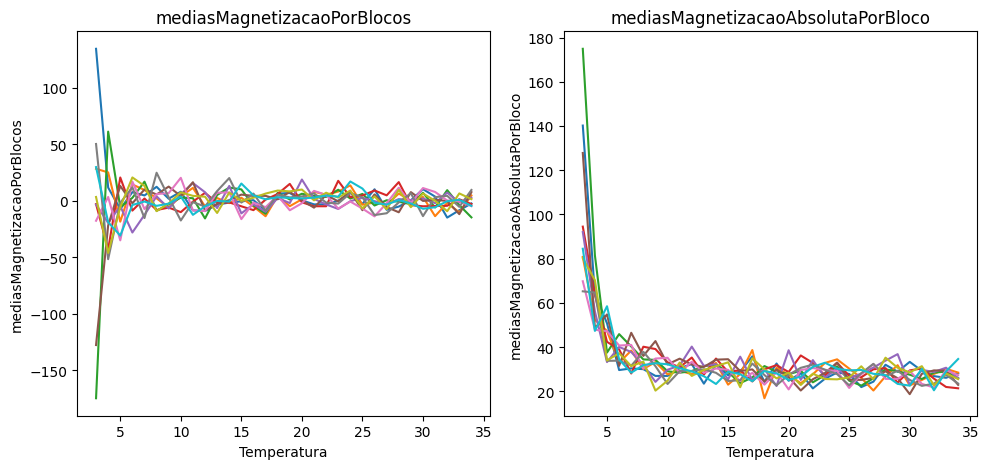

In [ ]:
simularVariacaoAtributoEmFuncaoTemperatura(
  temperaturaMinima = 3,
  temperaturaMaxima = TEMPERATURA_MAXIMA,
  quantidadeBlocos = 10,
  quantidadeSpins = TAMANHO_TERMALIZADOS[0],
  quantidadePassosDescartados = 600,
  quantidadePassosUteis = 400,
  atributo = "mediasMagnetizacaoPorBlocos",
  atributoErroEstatistico = "mediasMagnetizacaoAbsolutaPorBloco"
)

#### **Calor espec√≠fico em fun√ß√£o da temperatura**
---


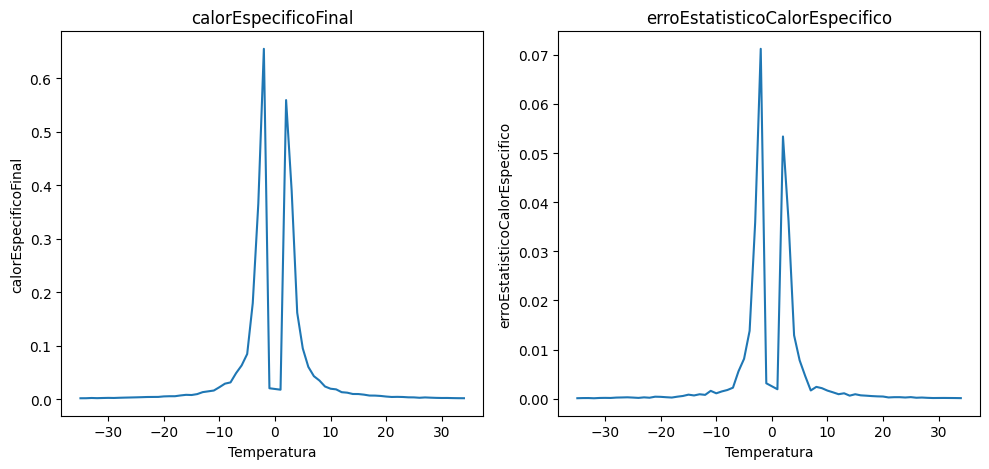

In [ ]:
simularVariacaoAtributoEmFuncaoTemperatura(
  temperaturaMinima = TEMPERATURA_MINIMA,
  temperaturaMaxima = TEMPERATURA_MAXIMA,
  quantidadeBlocos = 10,
  quantidadeSpins = TAMANHO_TERMALIZADOS[0],
  quantidadePassosDescartados = 600,
  quantidadePassosUteis = 400,
  atributo = "calorEspecificoFinal",
  atributoErroEstatistico = "erroEstatisticoCalorEspecifico"
)

#### **Suceptibilidade em fun√ß√£o da temperatura**
---


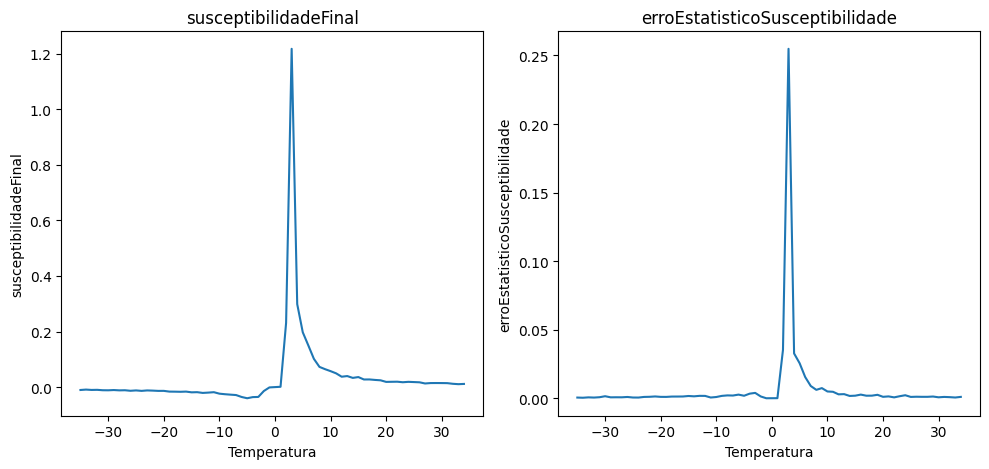

In [ ]:
simularVariacaoAtributoEmFuncaoTemperatura(
  temperaturaMinima = TEMPERATURA_MINIMA,
  temperaturaMaxima = TEMPERATURA_MAXIMA,
  quantidadeBlocos = 10,
  quantidadeSpins = TAMANHO_TERMALIZADOS[0],
  quantidadePassosDescartados = 600,
  quantidadePassosUteis = 400,
  atributo = "susceptibilidadeFinal",
  atributoErroEstatistico = "erroEstatisticoSusceptibilidade"
)

### **Comportamentos variando o tamanho**
---


In [ ]:
def plotVariacaoAtributoEmFuncaoTemperatura(
    temperaturaMinima: float,
    temperaturaMaxima: float,
    atributo: str,
    atributoErroEstatistico: str
  ) -> None:

  def simularVariacaoAtributoEmFuncaoTemperaturaGruped(
      temperaturaMinima: float,
      temperaturaMaxima: float,
      quantidadeBlocos: int,
      quantidadeSpins: int,
      quantidadePassosDescartados: int,
      quantidadePassosUteis: int,
      atributo: str,
      atributoErroEstatistico: str
    ) -> None:

    energiaPorSpinFinal: list[float] = []
    temperaturas: list[float] = []
    erros: list[float] = []

    for temperatura in range(temperaturaMinima, temperaturaMaxima):
      if temperatura == 0:
        continue

      resultados = calcularEstatisticasModeloIsing(
          quantidadeBlocos = quantidadeBlocos,
          quantidadeSpins = quantidadeSpins,
          temperatura = temperatura,
          quantidadePassosDescartados = quantidadePassosDescartados,
          quantidadePassosUteis = quantidadePassosUteis
      )

      energiaPorSpinFinal.append(resultados[atributo])
      temperaturas.append(temperatura)
      erros.append(resultados[atributoErroEstatistico])

    return {
      "temperaturas": temperaturas,
      "energiaPorSpinFinal": energiaPorSpinFinal,
      "erros": erros,
      "quantidadeSpins": quantidadeSpins
    }

  resultados = []
  figResultado, axResultado = plt.subplots(1, 2, figsize = (10, 5))

  for i in range(len(TAMANHO_TERMALIZADOS)):
    resultado = simularVariacaoAtributoEmFuncaoTemperaturaGruped(
        temperaturaMinima = temperaturaMinima,
        temperaturaMaxima = temperaturaMaxima,
        quantidadeBlocos = 10,
        quantidadeSpins = TAMANHO_TERMALIZADOS[i],
        quantidadePassosDescartados = 600,
        quantidadePassosUteis = 400,
        atributo = atributo,
        atributoErroEstatistico = atributoErroEstatistico
    )
    resultados.append(resultado)

  for i in range(len(resultados)):
    axResultado[0].plot(
        resultados[i]["temperaturas"],
        resultados[i]["energiaPorSpinFinal"],
        label = f"Rede: {int(np.sqrt(resultados[i]['quantidadeSpins']))}x{int(np.sqrt(resultados[i]['quantidadeSpins']))}"
    )
    axResultado[1].plot(
        resultados[i]["temperaturas"],
        resultados[i]["erros"],
        label = f"Rede: {int(np.sqrt(resultados[i]['quantidadeSpins']))}x{int(np.sqrt(resultados[i]['quantidadeSpins']))}"
    )

  axResultado[0].set_label("Temperatura")
  axResultado[0].set_ylabel(atributo)
  axResultado[0].set_title(atributo)
  axResultado[1].set_label("Temperatura")
  axResultado[1].set_ylabel(atributoErroEstatistico)
  axResultado[1].set_title(atributoErroEstatistico)
  axResultado[1].legend(loc = 'upper left', bbox_to_anchor = (1, 1))
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

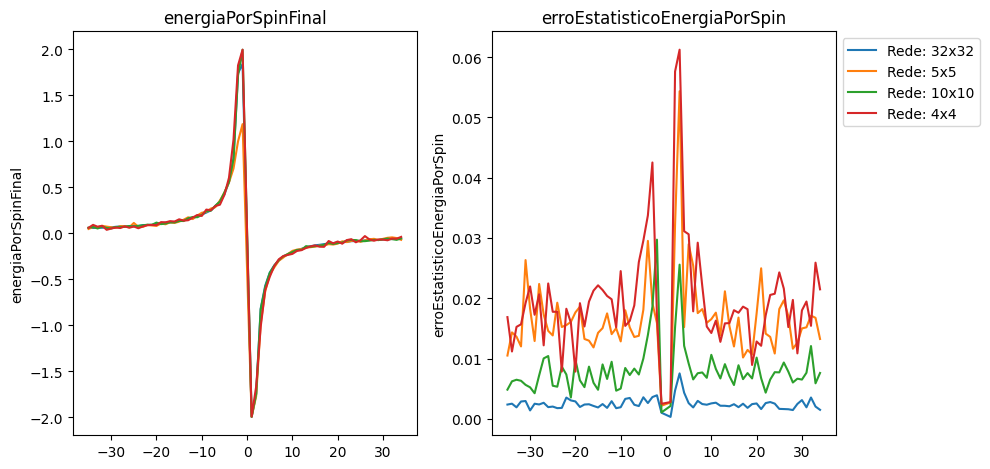

In [ ]:
plotVariacaoAtributoEmFuncaoTemperatura(
  temperaturaMinima = TEMPERATURA_MINIMA,
  temperaturaMaxima = TEMPERATURA_MAXIMA,
  atributo = "energiaPorSpinFinal",
  atributoErroEstatistico = "erroEstatisticoEnergiaPorSpin"
)

#### **Energia por spin em fun√ß√£o da temperatura**
---


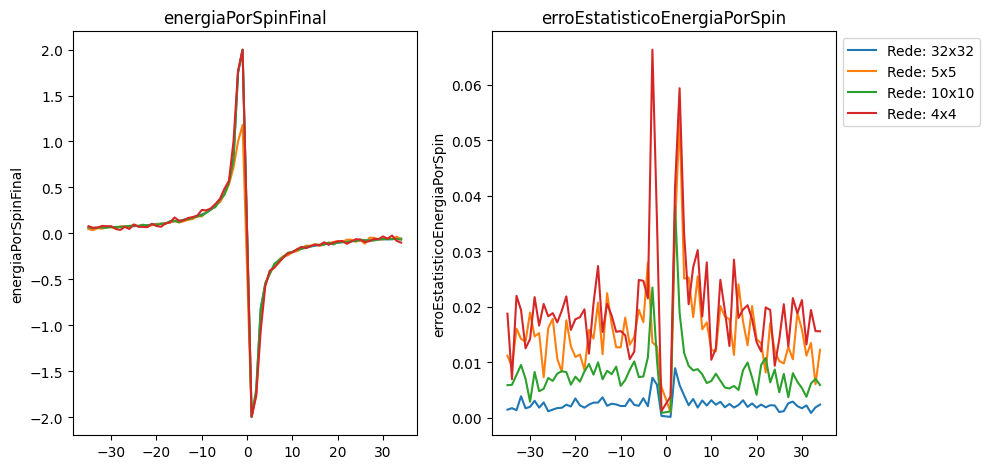

In [ ]:
plotVariacaoAtributoEmFuncaoTemperatura(
    temperaturaMinima = TEMPERATURA_MINIMA,
    temperaturaMaxima = TEMPERATURA_MAXIMA,
    atributo = "energiaPorSpinFinal",
    atributoErroEstatistico = "erroEstatisticoEnergiaPorSpin"
)

#### **Magnetiza√ß√£o em fun√ß√£o da temperatura**
---


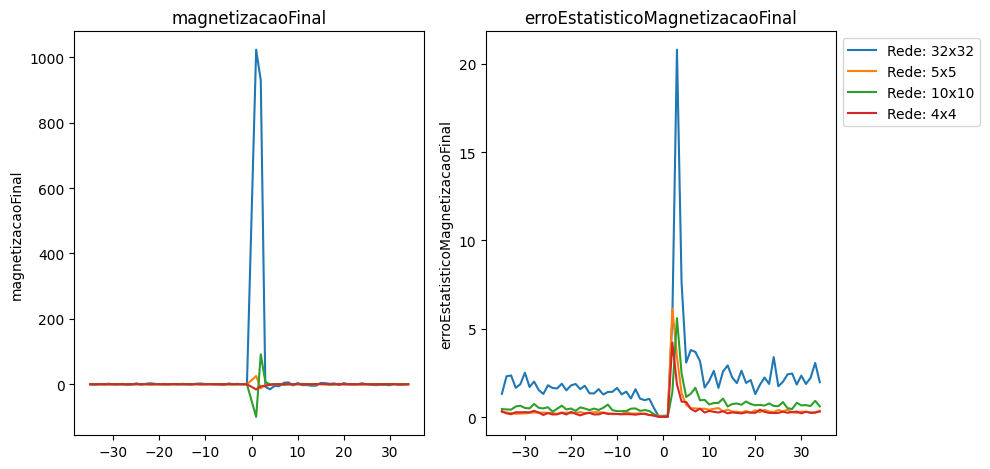

In [ ]:
plotVariacaoAtributoEmFuncaoTemperatura(
    temperaturaMinima = TEMPERATURA_MINIMA,
    temperaturaMaxima = TEMPERATURA_MAXIMA,
    atributo = "magnetizacaoFinal",
    atributoErroEstatistico = "erroEstatisticoMagnetizacaoFinal"
)

#### **Calor espec√≠fico em fun√ß√£o da temperatura**
---


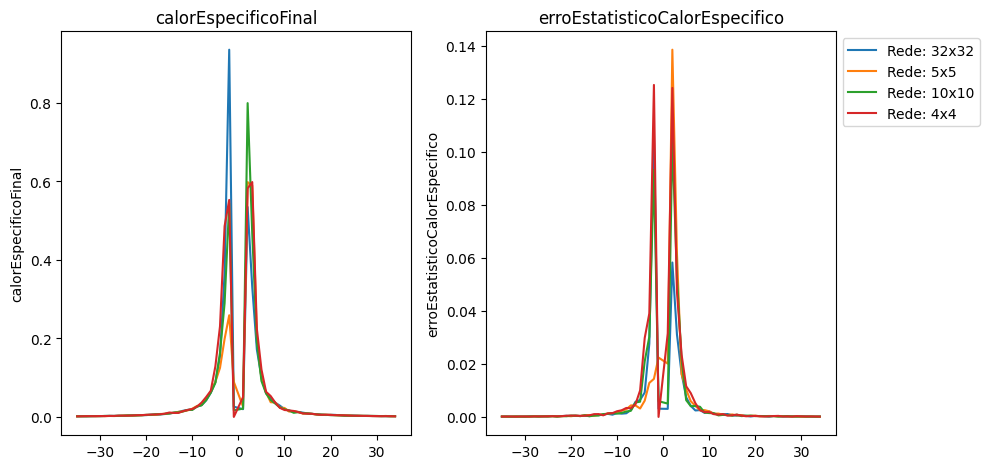

In [ ]:
plotVariacaoAtributoEmFuncaoTemperatura(
    temperaturaMinima = TEMPERATURA_MINIMA,
    temperaturaMaxima = TEMPERATURA_MAXIMA,
    atributo = "calorEspecificoFinal",
    atributoErroEstatistico = "erroEstatisticoCalorEspecifico"
)

#### **Suceptibilidade em fun√ß√£o da temperatura**
---


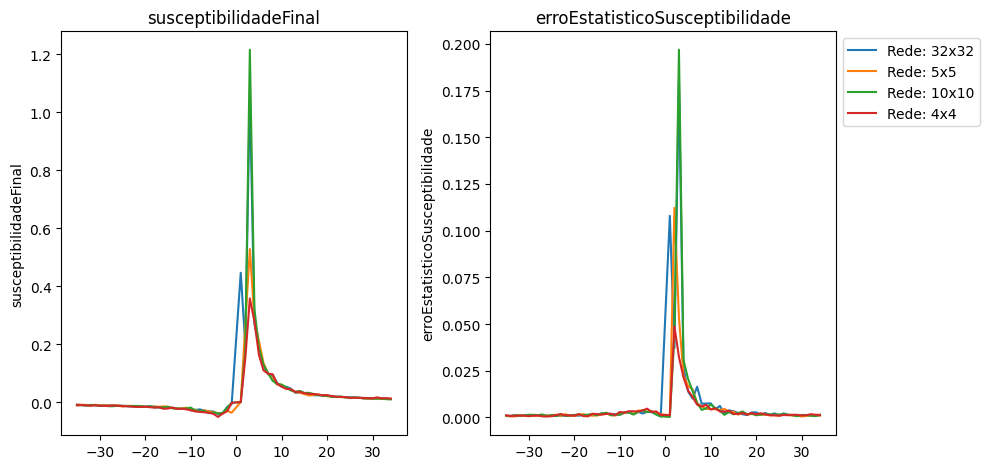

In [ ]:
plotVariacaoAtributoEmFuncaoTemperatura(
    temperaturaMinima = TEMPERATURA_MINIMA,
    temperaturaMaxima = TEMPERATURA_MAXIMA,
    atributo = "susceptibilidadeFinal",
    atributoErroEstatistico = "erroEstatisticoSusceptibilidade"
)

### **Respostas para quest√µes**
---


#### **Quest√£o 1)**
---


* Quais crit√©rios voc√™ utilizou para escolher os valores dos par√¢metros? Quais os principais fatores que nortearam suas escolhas finais?

 * N√≥s utilizamos como par√¢metros para a temperatura os valores de -35 a 35, o motivo desta escolha foi que ela permitiria um maior foco nos detalhes dos gr√°ficos de varia√ß√£o de temperatura, uma vez que esta j√° se estabiliza entre -20 e 20.
  
  * Para os parametros N<sub>term</sub> e N<sub>MCS</sub> utilizamos respectivamente os valores 600, equivalendo aos passos descart√°dos, e 400, equivalendo aos passos √∫teis. Escolhemos estes valores, pois tendo em vista as explora√ß√µes realizadas na primeira metade do trabalho foi apenas a partir do passo 600 que a simula√ß√£o de n√∫mero 2 convergiu.

  * Para o tamanho do sistema nos escolhemos os valores de 1024, 25, 100 e 16, pois foram para estas redes de spins que conseguimos resultados que termalizaram na primeira metade da atividade.

#### **Quest√£o 2)**
---


* Ao variar a temperatura, o que acontece com o valor das grandezas Energia por spin, Magnetiza√ß√£o por spin, calor espec√≠fico e susceptibilidade magn√©tica?
* Quais s√£o os limites para baixas e altas temperaturas?
* H√° algum pico ou vale?
* O comportamento est√° em acordo com o que voc√™ esperava?

O gr√°fico de energia por spin apresenta um comportamento interessante, apesar de possuir apenas derivadas positivas √© descont√≠nuo no ponto zero, em virtude do beta que n√£o pode ser definido quando h√° uma divis√£o por zero em seu c√°lculo, desta maneira, apesar das derivadas sempre positivas, ele se reduz ao passar do limite de zero pela direita para o limite de zero pela esquerda, respectivamente o pico(2) e o vale(-2) da fun√ß√£o. Isso n√£o bateu com as nossas expectativas uma vez que esper√°vamos que a energia sempre aumentaria quando a temperatura fosse aumentada, fato este que n√£o ocorreu, como indica a posi√ß√£o do pr√≥prio vale do gr√°fico.

No gr√°fico de magnetiza√ß√£o por spin, podemos notar que a magnetiza√ß√£o oscila em torno de zero pela maior parte do gr√°fico, apenas assumindo comportamento diferente ao aproximar-se de zero, come√ßando a assumir valores diferentes do nulo entre -5 e 5 graus celsius, este gr√°fico tamb√©m podemos notar, √© descont√≠nuo para o valor zero e seu limite pela direita √© o vale (-1000) do gr√°fico, enquanto seu limite pela esquerda √© seu pico(1000). J√° tendo analisado o comportamento do gr√°fico de energia por spin, este resultado n√£o √© surpreendente, apesar da intensidade do salto na magnetiza√ß√£o ao se aproximar muito de zero o ser.

No gr√°fico do calor espec√≠fico, temos novamente um comportamento diferente do padr√£o do resto do gr√°fico ao nos aproximarmos do zero, embora, neste caso, isso comece a causar altera√ß√µes no gr√°fico consideravelmente antes, nas marcas de -15 e 15 aproximadamente. H√° neste caso um pico(0.65) para o gr√°fico, o limite de zero pela direita, entretanto, n√£o h√° um vale uma vez que quando o gr√°fico alcan√ßa altas temperaturas ou baixas, ele tem valores menores que mais pr√≥ximo do 0, onde os valores oscilam. O comportamento do gr√°fico √© novamente esperado em partes, uma vez que dada as an√°lises anteriores era de se esperar maiores oscila√ß√µes pr√≥ximas de 0 e a descontinuidade neste valor, entretanto a aus√™ncia de vale n√£o foi prevista.

J√° no gr√°fico da Susceptibilidade, temos de novo um comportamento diferente pr√≥ximo ao zero, al√©m disso podemos observar que para temperaturas acima de zero a susceptibilidade apenas diminui e o faz mais rapidamente quando mais pr√≥xima de 0 √© a temperatura. O pico(0.8) da fun√ß√£o √© no limite pela esquerda de 0 e seu vale √© sutil se comparado √†s proximidades, mas ainda assim definido e aparece por volta de -3. Este comportamento acabou para fugir em muito do esperado, apenas sendo previs√≠vel o fato, a este ponto trivial, de que ele seria descont√≠nuo em 0.

#### **Quest√£o 3)**
---


* Ao variar o tamanho do sistema, como as curvas destas grandezas em fun√ß√£o da temperatura se modifica?

* H√° algum intervalo de temperaturas no qual as grandezas s√£o independentes do
tamanho do sistema?

* Em regi√µes onde h√° varia√ß√£o com o tamanho do sistema, como a
grandeza √© modificada quando ùêø aumenta?

Quando consideramos energia por spin e como ela se altera com diferentes L encontramos um comportamento peculiar, apesar de a maioria das valora√ß√µes de L ter um comportamento similar √© poss√≠vel notar uma diferen√ßa abrupta na 25, mas mesmo ela se comporta como as outras fora do intervalo de -5 a 5. Neste caso mesmo nesta regi√£o n√£o percebemos uma rela√ß√£o entre o crescimento de L e o comportamento da fun√ß√£o uma vez que L=16 se comporta como os demais valores e apenas L=25 varia.

Quando consideramos a magnetiza√ß√£o vemos uma figura bastante interessante, ela apenas apresenta varia√ß√£o quanto ao valor de L quando consideramos o intervalo entre -3 e 3, entretanto podemos perceber que tanto os picos quanto os vales da regi√£o se tornam consideravelmente mais acentuados quanto maior o valor de L, fora deste intervalo entretanto a valora√ß√£o de L n√£o parece ter influ√™ncia relevante.

Considerando o calor espec√≠fico teremos mais dificuldade em encontrar um padr√£o entre o aumento de L e uma altera√ß√£o no gr√°fico. √â fato que esta varia√ß√£o se faz presente entre -5 e 5, por√©m √© dif√≠cil conectar o comportamento das diferentes curvas aos seus valores de L. Fora deste intervalo a grandeza n√£o parece importar.

Neste √∫ltimo caso, a suceptibilidade, tamb√©m podemos notar que a varia√ß√£o se faz mais presente entre -5 e 5, por√©m diferentemente do caso anterior n√£o √© dif√≠cil relacionar o tamanho de L e o comportamento do gr√°fico, uma vez que ele √© uma rela√ß√£o direta, quando o tamanho de L aumenta aumenta tamb√©m o qu√£o acentuado √© o pico. Fora deste intervalo entretanto n√£o vemos influ√™ncia relevante do tamanho de L.

#### **Quest√£o 4)**
---


##### **Erro por temperatura**
---

In [ ]:
def plotErroMedioPorTemperatura(
    temperaturaMinima: float,
    temperaturaMaxima: float
  ) -> None:

  def simularVariacaoErroPorTemperatura(
      temperaturaMinima: float,
      temperaturaMaxima: float,
      quantidadeBlocos: int,
      quantidadeSpins: int,
      quantidadePassosDescartados: int,
      quantidadePassosUteis: int
    ) -> None:

    temperaturas: list[float] = []
    errosMedios: list[float] = []

    for temperatura in range(temperaturaMinima, temperaturaMaxima):
      if temperatura == 0:
        continue

      resultados = calcularEstatisticasModeloIsing(
          quantidadeBlocos = quantidadeBlocos,
          quantidadeSpins = quantidadeSpins,
          temperatura = temperatura,
          quantidadePassosDescartados = quantidadePassosDescartados,
          quantidadePassosUteis = quantidadePassosUteis
      )

      temperaturas.append(temperatura)
      errosMedios.append(resultados["erroMedio"])

    return {
      "temperaturas": temperaturas,
      "erros": errosMedios,
      "quantidadeSpins": quantidadeSpins
    }

  resultados = []
  figResultado, axResultado = plt.subplots(1, 1)

  for i in range(len(TAMANHO_TERMALIZADOS)):
    resultado = simularVariacaoErroPorTemperatura(
        temperaturaMinima = temperaturaMinima,
        temperaturaMaxima = temperaturaMaxima,
        quantidadeBlocos = 10,
        quantidadeSpins = TAMANHO_TERMALIZADOS[i],
        quantidadePassosDescartados = 600,
        quantidadePassosUteis = 400
    )
    resultados.append(resultado)

  for i in range(len(resultados)):
    axResultado.plot(
        resultados[i]["temperaturas"],
        resultados[i]["erros"],
        label = f"Rede: {int(np.sqrt(resultados[i]['quantidadeSpins']))}x{int(np.sqrt(resultados[i]['quantidadeSpins']))}"
    )

  axResultado.set_label("Temperatura")
  axResultado.set_ylabel("Erro m√©dio")
  axResultado.set_title("Erro m√©dio x Temperatura")
  axResultado.legend(loc = 'upper left', bbox_to_anchor = (1, 1))
  plt.show()

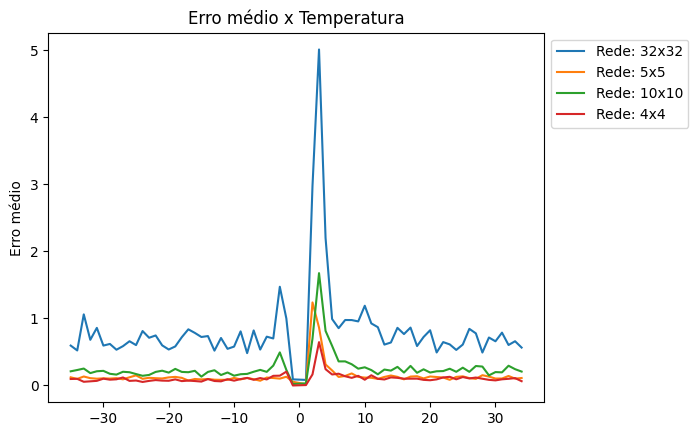

In [ ]:
plotErroMedioPorTemperatura(
    temperaturaMinima = TEMPERATURA_MINIMA,
    temperaturaMaxima = TEMPERATURA_MAXIMA
)

* Como √© o comportamento dos erros estat√≠sticos √† medida que a temperatura varia?

* Tem algum valor de temperatura em torno do qual os erros s√£o maiores?

* Voc√™ enxerga algum motivo para isso?

* Os erros estat√≠sticos dependem do tamanho do sistema? Como?

Como podemos notar no gr√°fico o erro tende a ser mais pronunciado entre 0 e aproximadamente 5, mas mesmo fora deste intervalo ainda podemos ver que h√° oscila√ß√µes no erro na medida que a temperatura varia. Suponho que como esta √°rea possui maior varia√ß√£o em todas as grandezas, faz sentido que erros estejam mais propensos a surgir nela. J√° quando tratamos do tamanho, podemos observar que quando olhamos a grandeza da magnetiza√ß√£o podemos ver que um maior valor de L representa um maior erro estat√≠stico, o oposto do comportamento de outras grandezas nas quais um valor de L maior se traduz em um erro menos pronunciado. Desta forma, exceto pelo comportamento da magnetiza√ß√£o, a distribui√ß√£o dos erros estat√≠sticos est√° ocorrendo como esperada por n√≥s, e estamos intrigadas com o comportamento exibido pela magnetiza√ß√£o.

#### **Quest√£o 5)**
---


* Com base no comportamento encontrado, identifique poss√≠veis fases do sistema,
descrevendo as principais caracter√≠sticas das fases encontradas.

Existem duas fases presentes no sistema, separadas por uma transi√ß√£o pr√≥xima do valor nulo. Chamemos a primeira delas de fase negativa, pois ela se localiza em valores de temperatura negativos, e a segunda de fase positiva, pois ela se localiza em valores de temperatura positvos. Na fase negativa temos uma energia por spin consistentemente no zero, entretanto na fase positiva a energia por spin se altera se mantendo consistente em -0,5, no lugar de zero como na fase anterior. √â curioso notar que, contra as nossas expectativas, outras grandezas n√£o pareceram variar muito da fase negativa para a positiva. Durante a transi√ß√£o de uma fase para outra no entanto houve varia√ß√£o de todas as grandezas, por√©m interessantemente, exceto pela energia por spin, as grandezas retornaram aos seus valores que possuiam na fase anterior √† transi√ß√£o.

#### **Quest√£o 6)**
---


* Estime, utilizando os dados das suas simula√ß√µes, a temperatura de transi√ß√£o de fase do sistema no limite termodin√¢mico, i.e., para o limite em que o tamanho do sistema √© infinito.

Como pudemos oberservar nos gr√°ficos a grande mudan√ßa acontece pr√≥xima de zero, assim sendo quando o tamanho do sistema tender ao infinito a temperatura de transi√ß√£o h√°vera de tender √† zero.